In [1]:
from src.preprocessing import get_data_loader
from src.models.components import HSM,PREDICTOR
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

In [2]:
class RUL_Predictor(nn.Module):
    def __init__(self, input_dim=65):
        super(RUL_Predictor, self).__init__()
        self.hsm = HSM(output_dim=64)
        self.predictor = PREDICTOR(input_dim)

    def forward(self, x, t):
        self.hsm.eval()
        self.predictor.eval()
        hidden = self.hsm(x)
        hidden.requires_grad_(True) 
        output = self.predictor(torch.cat([hidden, t], dim=1))
        return output, hidden

In [3]:
net = RUL_Predictor()

D:\anaconda\envs\mkdpinn\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [4]:
net.hsm.load_state_dict(torch.load('./Result/FD004/hsm.pth'))
net.predictor.load_state_dict(torch.load('./Result/FD004/predictor.pth'))

<All keys matched successfully>

In [5]:
sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
# [6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25]
# windows length
sequence_length = 15
# smoothing intensity
alpha = 0.1
# max RUL
threshold = 125
batch_size = 128
train_loader, valid_loader, test_loader = get_data_loader('FD004',
                                             sensors=sensors, sequence_length=sequence_length, alpha=alpha, threshold=125,
                                             batch_size=batch_size, train_size=0.8)


In [6]:
for x_test,t_test,y_test in test_loader:
    break

In [7]:
y_pred,_ = net(x_test,t_test)
y_pred = y_pred.detach().numpy()
y_test = y_test.detach().numpy()

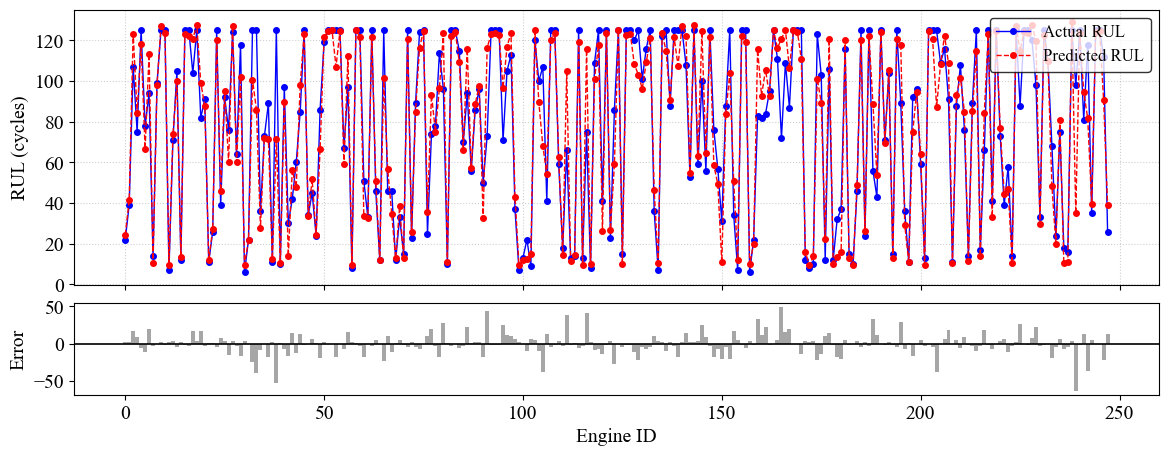

In [8]:
plt.rcParams['font.family'] = 'Times New Roman' 
fontsize = 22

actual_values = y_test
predicted_values = y_pred

actual_values = np.array(actual_values).flatten()
predicted_values = np.array(predicted_values).flatten()

# Check if the lengths are the same after reshaping.  Raise error if different
if len(actual_values) != len(predicted_values):
    raise ValueError("The lengths of actual and predicted values must be the same after flattening.")

# --- Calculate errors ---
# --- Set the step size for the x-axis ---
step_size = 1  

# --- Create the x-axis values based on the step size ---
steps = np.arange(0, len(actual_values) * step_size, step_size)
# steps = range(len(actual_values))
errors = predicted_values - actual_values

# --- Create subplots ---
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 5), gridspec_kw={'height_ratios': [3, 1]})

# --- Plot 1: Actual vs. Predicted ---
ax1.plot(steps, actual_values, marker='o', linestyle='-', color='b', linewidth=1,label='Actual RUL', markersize=4)
ax1.plot(steps, predicted_values, marker='o', linestyle='--', color='r', linewidth=1,label='Predicted RUL', markersize=4)

ax1.set_ylabel('RUL (cycles)', fontsize=14)
# ax1.set_title('Model Prediction vs. Actual Values', fontsize=16)
ax1.legend(loc="upper right", fontsize=12, frameon=True, edgecolor='black')
ax1.grid(True, linestyle=':', alpha=0.6)

# --- Plot 2: Prediction Errors ---
ax2.bar(steps, errors, color='gray', alpha=0.7, width=step_size * 1)
ax2.set_xlabel('Engine ID', fontsize=14)
ax2.set_ylabel('Error', fontsize=14)
ax2.axhline(0, color='black', linewidth=1.2)  # Zero error line
#ax2.grid(True, which='both', linestyle='-', alpha=0.3)

# --- Adjust spacing ---
plt.subplots_adjust(hspace=0.1)

# --- Set background colors ---
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax2.set_facecolor('white')

# --- Customize tick label font size ---
tick_label_fontsize = 14  # Set your desired font size here

ax1.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
plt.savefig('./Result/prediction on FD004.svg')


# --- Display the plot ---
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error

In [10]:
print(f'RMSE on FD004: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE on FD004: 13.596931457519531
